In [2]:
import pandas as pd 
df = pd.read_excel("D:\IPL_Auction_Analytics\data\IPL_Bowler_Detailed_Data.xls")

df.head()


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,29504,2023-04-12,Neutral,Powerplay,1,1,Bowler B,17.97,133.25,0,1
1,96402,2023-11-30,Batting,Powerplay,5,1,Bowler A,20.51,119.98,0,0
2,27383,2022-11-07,Neutral,Powerplay,1,5,Bowler B,30.05,124.73,2,0
3,99624,2022-04-10,Batting,Powerplay,5,3,Bowler B,21.29,147.69,1,0
4,65569,2023-06-23,Neutral,Powerplay,5,3,Bowler B,34.89,117.51,0,0


In [ ]:
df.columns

Index(['Match_ID', 'Match_Date', 'Pitch_Type', 'Phase', 'Over', 'Ball',
       'Bowler', 'Batter_Avg', 'Batter_SR', 'Runs_Conceded', 'Is_Wicket'],
      dtype='object')

In [7]:
df.shape

(4800, 11)

In [9]:
import pandas as pd

# Convert date to datetime format
df['Match_Date'] = pd.to_datetime(df['Match_Date'], errors='coerce')

# Ensure numeric columns are numeric
numeric_cols = ['Batter_Avg', 'Batter_SR', 'Runs_Conceded', 'Over', 'Ball']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Replace missing values if any
df.fillna({
    'Runs_Conceded': 0,
    'Is_Wicket': 0
}, inplace=True)

# Add helper columns
df['Runs_Conceded'] = df['Runs_Conceded'].astype(int)
df['Is_Wicket'] = df['Is_Wicket'].astype(int)

df.head()


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,29504,2023-04-12,Neutral,Powerplay,1,1,Bowler B,17.97,133.25,0,1
1,96402,2023-11-30,Batting,Powerplay,5,1,Bowler A,20.51,119.98,0,0
2,27383,2022-11-07,Neutral,Powerplay,1,5,Bowler B,30.05,124.73,2,0
3,99624,2022-04-10,Batting,Powerplay,5,3,Bowler B,21.29,147.69,1,0
4,65569,2023-06-23,Neutral,Powerplay,5,3,Bowler B,34.89,117.51,0,0


In [10]:
bowler_group = df.groupby('Bowler').agg({
    'Runs_Conceded': 'sum',
    'Is_Wicket': 'sum',
    'Over': 'count',   # counts balls
    'Match_ID': 'nunique'
}).rename(columns={'Over': 'Balls_Bowled', 'Match_ID': 'Matches_Played'})

bowler_group.head()


,Runs_Conceded,Is_Wicket,Balls_Bowled,Matches_Played
Bowler,,,,
Bowler A,2935,108,2400,100
Bowler B,3654,231,2400,100


In [11]:
bowler_group['Overs_Bowled'] = bowler_group['Balls_Bowled'] / 6
bowler_group['Strike_Rate'] = bowler_group['Balls_Bowled'] / bowler_group['Is_Wicket'].replace(0, float('nan'))
bowler_group['Economy'] = bowler_group['Runs_Conceded'] / bowler_group['Overs_Bowled']
bowler_group['Bowling_Average'] = bowler_group['Runs_Conceded'] / bowler_group['Is_Wicket'].replace(0, float('nan'))

bowler_group.head()


,Runs_Conceded,Is_Wicket,Balls_Bowled,Matches_Played,Overs_Bowled,Strike_Rate,Economy,Bowling_Average
Bowler,,,,,,,,
Bowler A,2935,108,2400,100,400.0,22.222222,7.3375,27.175926
Bowler B,3654,231,2400,100,400.0,10.389610,9.1350,15.818182


In [12]:
def pressure_score(row):
    score = 0

    # Phase weights
    if row['Phase'] == 'Death':
        score += 30
    elif row['Phase'] == 'Powerplay':
        score += 15

    # Batter difficulty
    score += row['Batter_Avg'] * 0.1
    score += row['Batter_SR'] * 0.05

    # Pitch type
    if row['Pitch_Type'] == 'Batting':
        score += 10
    elif row['Pitch_Type'] == 'Bowling':
        score -= 10

    return score

df['Pressure'] = df.apply(pressure_score, axis=1)

pressure_metrics = df.groupby('Bowler')['Pressure'].mean().to_frame('Avg_Pressure_Faced')

pressure_metrics.head()


,Avg_Pressure_Faced
Bowler,
Bowler A,33.541655
Bowler B,33.852136


In [13]:
final_df = bowler_group.merge(pressure_metrics, on='Bowler', how='left')
final_df.head()


,Runs_Conceded,Is_Wicket,Balls_Bowled,Matches_Played,Overs_Bowled,Strike_Rate,Economy,Bowling_Average,Avg_Pressure_Faced
Bowler,,,,,,,,,
Bowler A,2935,108,2400,100,400.0,22.222222,7.3375,27.175926,33.541655
Bowler B,3654,231,2400,100,400.0,10.389610,9.1350,15.818182,33.852136


In [14]:
final_df['Auction_Score'] = (
    (100 / final_df['Economy']) * 0.35 +        # Better economy = higher score
    (final_df['Is_Wicket'] * 0.5) +             # Wickets are important
    ((1 / final_df['Strike_Rate']) * 250) * 0.25 +  # Better strike rate = higher impact
    (final_df['Avg_Pressure_Faced'] * 0.2) -    # Handles pressure well
    (final_df['Bowling_Average'] * 0.1)         # Lower bowling avg = good
)


In [15]:
final_df_sorted = final_df.sort_values(by='Auction_Score', ascending=False)
final_df_sorted.head(10)


,Runs_Conceded,Is_Wicket,Balls_Bowled,Matches_Played,Overs_Bowled,Strike_Rate,Economy,Bowling_Average,Avg_Pressure_Faced,Auction_Score
Bowler,,,,,,,,,,
Bowler B,3654,231,2400,100,400.0,10.389610,9.1350,15.818182,33.852136,130.535652
Bowler A,2935,108,2400,100,400.0,22.222222,7.3375,27.175926,33.541655,65.573256


Matplotlib is building the font cache; this may take a moment.


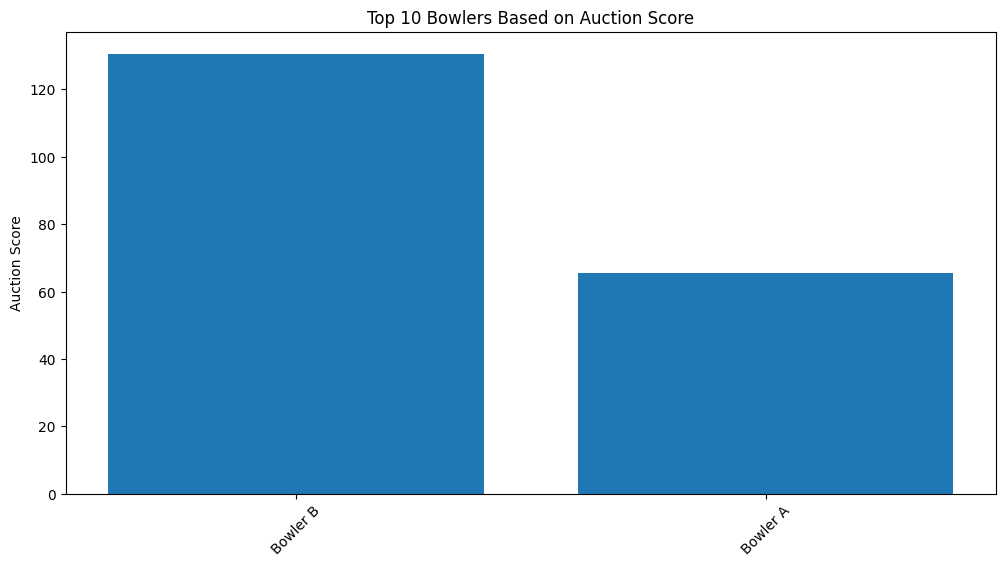

In [16]:
import matplotlib.pyplot as plt

top10 = final_df_sorted.head(10)

plt.figure(figsize=(12,6))
plt.bar(top10.index, top10['Auction_Score'])
plt.xticks(rotation=45)
plt.ylabel("Auction Score")
plt.title("Top 10 Bowlers Based on Auction Score")
plt.show()


In [17]:
final_df_sorted['Estimated_Price'] = final_df_sorted['Auction_Score'] * 2.5


In [18]:
final_df['Auction_Score'].head()


Bowler
Bowler A     65.573256
Bowler B    130.535652
Name: Auction_Score, dtype: float64

In [19]:
final_df_sorted.head(10)


,Runs_Conceded,Is_Wicket,Balls_Bowled,Matches_Played,Overs_Bowled,Strike_Rate,Economy,Bowling_Average,Avg_Pressure_Faced,Auction_Score,Estimated_Price
Bowler,,,,,,,,,,,
Bowler B,3654,231,2400,100,400.0,10.389610,9.1350,15.818182,33.852136,130.535652,326.339129
Bowler A,2935,108,2400,100,400.0,22.222222,7.3375,27.175926,33.541655,65.573256,163.933139
